# Introduction

This work presents a constrained combinatorial optimization approach to the **Sports League Assignment Problem** using **Genetic Algorithms (GAs)**. The objective is to allocate a fixed pool of professional players into a set of 5 structurally valid teams in such a way that the **standard deviation of the teams\\\\' average skill ratings** is minimized—promoting competitive balance across the league.

Each player is defined by three attributes: **position** (one of `GK`, `DEF`, `MID`, `FWD`), **skill rating** (a numerical measure of ability), and **cost** (in million euros). A valid solution must satisfy the following **hard constraints**:

- Each team must consist of exactly **7 players**, with a specific positional structure: **1 GK, 2 DEF, 2 MID, and 2 FWD**
- Each team must have a **total cost ≤ 750 million €**
- Each player must be assigned to **exactly one team** (no overlaps)

The **search space** is therefore highly constrained and discrete, and infeasible configurations are explicitly excluded from the solution space. The optimization objective is to identify league configurations where teams are not only valid but also **skill-balanced**, quantified by the **standard deviation of average skill ratings across teams**, which serves as the **fitness function** (to be minimized).

To address this, we implement a domain-adapted **Genetic Algorithm framework** featuring:

- A custom **representation** based on team-to-player mappings
- Validity-preserving **mutation** and **crossover** operators
- Multiple **selection mechanisms**
- Optional **elitism** and population-level diversity handling

This report provides a formal problem definition, details the design of the solution encoding and operators, and presents empirical results comparing different GA configurations. The overall objective is to evaluate how well GA-based metaheuristics can navigate this complex constrained search space and evolve solutions that both satisfy domain constraints and optimize league balance.

In addition to Genetic Algorithms, this project also explores and evaluates alternative optimization strategies, such as **Hill Climbing** and **Simulated Annealing**, which are well-suited for navigating discrete and constrained search spaces. These algorithms offer different trade-offs in terms of exploration, exploitation, and convergence speed. By implementing and benchmarking multiple approaches on the same problem, we aim to gain deeper insights into their relative effectiveness and robustness when applied to complex constrained optimization tasks such as the Sports League Assignment. This comparative analysis enhances the interpretability of results and supports a broader understanding of the strengths and limitations of population-based versus local search-based heuristics.

## Cell 1: Setup and Critical Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from solution import LeagueSolution, LeagueHillClimbingSolution, LeagueSASolution
from evolution import genetic_algorithm, hill_climbing, simulated_annealing_for_league
from operators import (
    # Base Mutations (examples, can be used for comparison)
    mutate_swap, 
    mutate_team_shift,
    mutate_shuffle_team, 
    # New/Adapted Mutations
    mutate_swap_constrained,
    mutate_targeted_player_exchange,
    mutate_shuffle_within_team_constrained,
    # Base Crossovers (examples, can be used for comparison)
    crossover_one_point,
    crossover_uniform,
    # New/Adapted Crossovers
    crossover_one_point_prefer_valid,
    crossover_uniform_prefer_valid,
    # Base Selections (examples, can be used for comparison)
    selection_ranking,
    # New/Adapted Selections
    selection_tournament_variable_k,
    selection_boltzmann
)

# Load player data
players_df = pd.read_csv("players.csv", sep=";")
players = players_df.to_dict(orient="records")

## Cell 2: Further Setup, Data Inspection, and Experiment Parameters

In [2]:
# Define problem parameters
NUM_TEAMS = 5
TEAM_SIZE = 7
MAX_BUDGET = 750

# Define number of runs for stochastic algorithms
NUM_RUNS = 30 # Parameter for number of runs (e.g., 10, 30)

print("Player data loaded successfully.") 
print(f"Total players: {len(players)}")
if players:
    print("First player data:", players[0])
players_df.head()
print(f"\nStochastic algorithms (SA, GA) will be run {NUM_RUNS} times each.")

Player data loaded successfully.
Total players: 35
First player data: {'Unnamed: 0': 0, 'Name': 'Alex Carter', 'Position': 'GK', 'Skill': 85, 'Salary (€M)': 90}

Stochastic algorithms (SA, GA) will be run 30 times each.


## Problem Representation Details (from original notebook)

### A. Team-based Representation (Structured Encoding)

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{t_1, t_2, \dots, t_5\}$ be the set of teams

Define the assignment function:

$$
A: P \rightarrow T
$$

such that each player is assigned to exactly one team, and the following constraints are satisfied:

**Team Size:**

$$
\forall t_j \in T,\quad \left|\{p_i \in P \mid A(p_i) = t_j\}\right| = 7
$$

**Positional Requirements:** For each team $t_j \in T$:

$$
\begin{aligned}
&|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{GK}\}| = 1 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{DEF}\}| = 2 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{MID}\}| = 2 \\\n# &|\{p_i \in P \mid A(p_i) = t_j \land pos(p_i) = \text{FWD}\}| = 2
\end{aligned}
$$

**Budget Constraint:**

$$
\forall t_j \in T,\quad \sum_{p_i \in P \mid A(p_i) = t_j} cost(p_i) \leq 750
$$

**Objective Function:** Minimize the standard deviation of average team skill:

$$
f(A) = \sigma\left(\left\{\frac{1}{7} \sum_{p_i \in P \mid A(p_i) = t_j} skill(p_i) \,\middle|\, t_j \in T\right\}\right)
$$

### B. Player-assignment Representation (Linear Encoding) - This is what is implemented

Let:

- $P = \{p_1, p_2, \dots, p_{35}\}$ be the set of players  
- $T = \{0, 1, 2, 3, 4\}$ be team IDs

A solution is represented by a vector:

$$
\mathbf{a} = [a_1, a_2, \dots, a_{35}] \in T^{35}
$$

where $a_i$ is the team assignment for player $p_i$.

**Team Definitions:**

$$
P_j = \{p_i \in P \mid a_i = j\}, \quad \forall j \in T
$$

**Constraints:**

$$
|P_j| = 7 \quad \text{and}
$$

$$
\begin{aligned}
&|\{p \in P_j \mid pos(p) = \text{GK}\}| = 1 \\\n# &|\{p \in P_j \mid pos(p) = \text{DEF}\}| = 2 \\\n# &|\{p \in P_j \mid pos(p) = \text{MID}\}| = 2 \\\n# &|\{p \in P_j \mid pos(p) = \text{FWD}\}| = 2 \\\n# &\sum_{p \in P_j} cost(p) \leq 750
\end{aligned}
$$

**Objective Function:**

$$
f(\mathbf{a}) = \sigma\left(\left\{\frac{1}{7} \sum_{p \in P_j} skill(p) \,\middle|\, j \in T\right\}\right)
$$

## 1. Hill Climbing

Hill Climbing is a local search algorithm that iteratively moves towards an increasingly optimal solution by choosing the best neighbor. It is simple and fast but can get stuck in local optima. It is run once as it is deterministic for a given starting point.

Running Hill Climbing Algorithm (1 run)...


Hill Climbing finished in 0.81 seconds.
Best solution found by Hill Climbing: [3, 4, 1, 0, 2, 3, 0, 4, 0, 4, 3, 1, 4, 3, 2, 4, 2, 1, 3, 1, 0, 2, 3, 4, 2, 1, 0, 0, 1, 1, 2, 0, 4, 2, 3]
Best fitness: 0.05714285714285552


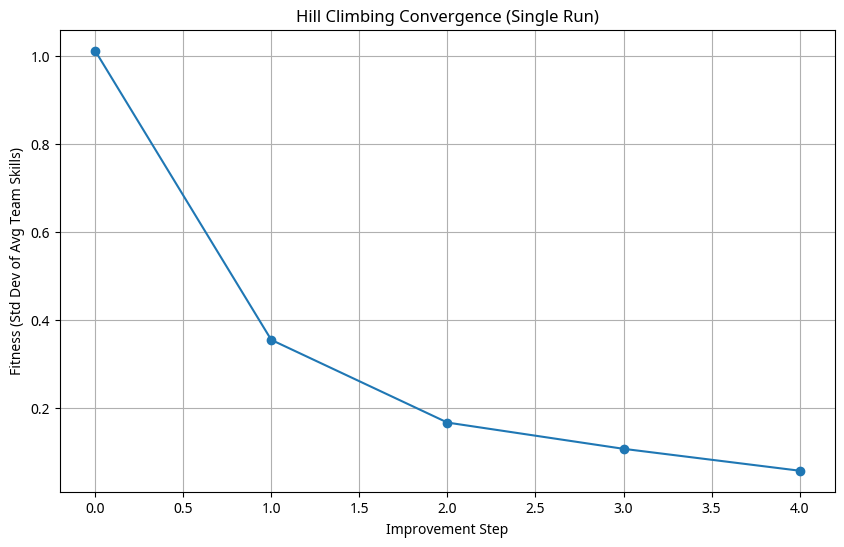

In [3]:
print("Running Hill Climbing Algorithm (1 run)...")
start_time_hc = time.time()
hc_solution_obj, hc_fitness_val, hc_history_convergence = hill_climbing(players, max_iterations=1000, verbose=False) # Verbose set to False for cleaner output during multiple runs elsewhere
end_time_hc = time.time()
hc_exec_time = end_time_hc - start_time_hc

print(f"Hill Climbing finished in {hc_exec_time:.2f} seconds.")
if hc_solution_obj:
    print(f"Best solution found by Hill Climbing: {hc_solution_obj.assignment}")
    print(f"Best fitness: {hc_fitness_val}")
else:
    print("Hill Climbing did not find a valid solution.")

# Plot Hill Climbing History
plt.figure(figsize=(10, 6))
plt.plot(hc_history_convergence, marker='o', linestyle='-')
plt.title('Hill Climbing Convergence (Single Run)')
plt.xlabel('Improvement Step')
plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
plt.grid(True)
plt.show()

## 2. Simulated Annealing

Simulated Annealing is a probabilistic technique. We will run it multiple times to get statistical measures of its performance.

Running Simulated Annealing Algorithm (30 runs)...
  SA Run 1/30...


  SA Run 2/30...


  SA Run 3/30...


  SA Run 4/30...


  SA Run 5/30...


  SA Run 6/30...


  SA Run 7/30...


  SA Run 8/30...


  SA Run 9/30...


  SA Run 10/30...


  SA Run 11/30...


  SA Run 12/30...


  SA Run 13/30...


  SA Run 14/30...


  SA Run 15/30...


  SA Run 16/30...


  SA Run 17/30...


  SA Run 18/30...


  SA Run 19/30...


  SA Run 20/30...


  SA Run 21/30...


  SA Run 22/30...


  SA Run 23/30...


  SA Run 24/30...


  SA Run 25/30...


  SA Run 26/30...


  SA Run 27/30...


  SA Run 28/30...


  SA Run 29/30...


  SA Run 30/30...


Simulated Annealing (30 runs) finished.
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 10.39s
  Overall Best SA Fitness: 0.0571


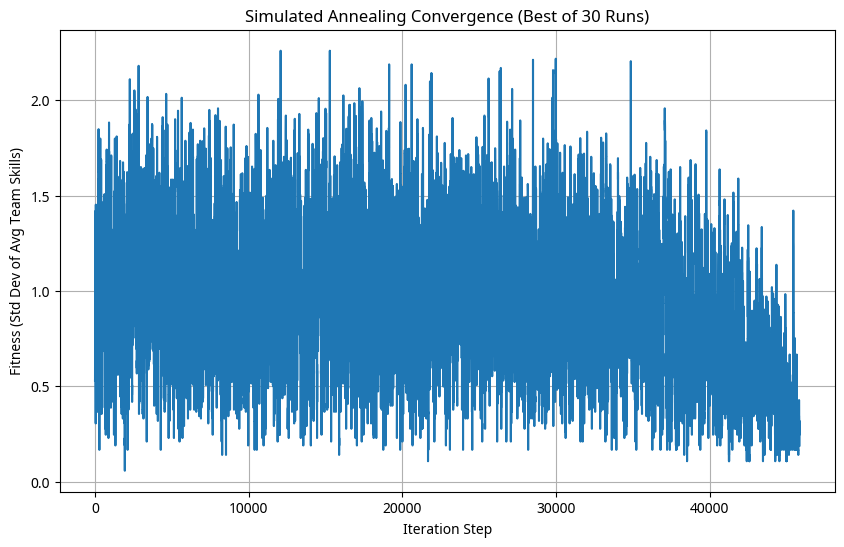

In [4]:
print(f"Running Simulated Annealing Algorithm ({NUM_RUNS} runs)...")

sa_all_fitness_values = []
sa_all_exec_times = []
best_sa_solution_overall = None
best_sa_fitness_overall = float('inf')
best_sa_history_overall = []

sa_params = {
    'initial_temp': 1000,
    'final_temp': 0.1,
    'alpha': 0.99,
    'iterations_per_temp': 50
}

for i in range(NUM_RUNS):
    print(f"  SA Run {i+1}/{NUM_RUNS}...")
    start_time_sa_run = time.time()
    sa_solution_run, sa_fitness_run, sa_history_run = simulated_annealing_for_league(
        players,
        initial_temp=sa_params['initial_temp'],
        final_temp=sa_params['final_temp'],
        alpha=sa_params['alpha'],
        iterations_per_temp=sa_params['iterations_per_temp'],
        verbose=False # Keep verbose False for multiple runs
    )
    end_time_sa_run = time.time()
    
    if sa_solution_run:
        sa_all_fitness_values.append(sa_fitness_run)
        sa_all_exec_times.append(end_time_sa_run - start_time_sa_run)
        if sa_fitness_run < best_sa_fitness_overall:
            best_sa_fitness_overall = sa_fitness_run
            best_sa_solution_overall = sa_solution_run
            best_sa_history_overall = sa_history_run
    else:
        print(f"  SA Run {i+1} did not find a valid solution.")

sa_mean_fitness = np.mean(sa_all_fitness_values) if sa_all_fitness_values else float('nan')
sa_std_fitness = np.std(sa_all_fitness_values) if sa_all_fitness_values else float('nan')
sa_mean_exec_time = np.mean(sa_all_exec_times) if sa_all_exec_times else float('nan')

print(f"Simulated Annealing ({NUM_RUNS} runs) finished.")
print(f"  Mean Best Fitness: {sa_mean_fitness:.4f}")
print(f"  Std Dev Best Fitness: {sa_std_fitness:.4f}")
print(f"  Mean Execution Time: {sa_mean_exec_time:.2f}s")
if best_sa_solution_overall:
    print(f"  Overall Best SA Fitness: {best_sa_fitness_overall:.4f}")
    # print(f"  Overall Best SA Solution: {best_sa_solution_overall.assignment}")

    # Plot Simulated Annealing History for the best run
    plt.figure(figsize=(10, 6))
    plt.plot(best_sa_history_overall, linestyle='-')
    plt.title(f'Simulated Annealing Convergence (Best of {NUM_RUNS} Runs)')
    plt.xlabel('Iteration Step')
    plt.ylabel('Fitness (Std Dev of Avg Team Skills)')
    plt.grid(True)
    plt.show()
else:
    print("Simulated Annealing did not find any valid solution across all runs.")

## 3. Genetic Algorithm with New/Adapted Operators

Genetic Algorithms are also stochastic. We will run each configuration multiple times.

Running Genetic Algorithm with NEW/ADAPTED operator configurations (30 runs each)...

Running GA_Config_1 (SwapConst,1PtPreferV,TournVarK) for 30 runs...
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 1 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 2 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 3/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 3 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 4/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 4 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 5/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 5 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 6/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 7 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 8/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 8 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 9/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 9 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 10 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 11/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 11 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 12/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 12 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 13 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 14/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 14 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 15/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 15 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 16/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 16 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 17/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 17 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 18/30...


  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 19/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 19 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 20/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 20 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 21/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 21 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 22 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 23/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 23 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 24/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 24 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 25 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 26/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 26 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 27/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 27 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 28 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 29/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 29 failed to produce a solution.
  GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 30/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_1 (SwapConst,1PtPreferV,TournVarK) - Run 30 failed to produce a solution.
GA_Config_1 (SwapConst,1PtPreferV,TournVarK) (30 runs) summary:
  Mean Best Fitness: 0.0820
  Std Dev Best Fitness: 0.0249
  Mean Execution Time: 1.85s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_2 (TargetExch,UnifPreferV,Ranking) for 30 runs...
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 1 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 2 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 3/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 3 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 4/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 5/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 5 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 6/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 7 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 8/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 8 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 9/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 9 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 10 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 11/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 11 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 12/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 12 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 13 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 14/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 14 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 15 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 16/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 16 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 17/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 17 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 18/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 18 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 19/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 19 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 20/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 20 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 21/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 21 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 22/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 23/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 23 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 24/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 24 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 25/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 25 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 26/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 26 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 27/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 28/30...


  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 29/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 29 failed to produce a solution.
  GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 30/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_2 (TargetExch,UnifPreferV,Ranking) - Run 30 failed to produce a solution.
GA_Config_2 (TargetExch,UnifPreferV,Ranking) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 22.30s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) for 30 runs...
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 1 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 2/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 2 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 3/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 3 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 4/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 4 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 5/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 5 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 6/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 7 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 8/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 8 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 9/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 9 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 10/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 10 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 11/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 11 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 12/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 12 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 13/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 13 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 14/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 14 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 15 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 16/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 17/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 17 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 18/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 18 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 19/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 19 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 20/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 20 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 21/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 21 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 22 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 23/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 23 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 24/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 24 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 25 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 26/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 26 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 27/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 27 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 28 failed to produce a solution.
  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 29/30...


  GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 30/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) - Run 30 failed to produce a solution.
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann) (30 runs) summary:
  Mean Best Fitness: 0.0936
  Std Dev Best Fitness: 0.0516
  Mean Execution Time: 20.66s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------

Running GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) for 30 runs...
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 1/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 1 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 2/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 2 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 3/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 3 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 4/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 4 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 5/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 5 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 6/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 6 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 7/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 7 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 8/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 8 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 9/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 10/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 10 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 11/30...


  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 12/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 12 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 13/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 13 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 14/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 14 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 15/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 15 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 16/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 16 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 17/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 17 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 18/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 18 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 19/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 19 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 20/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 20 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 21/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 21 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 22/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 22 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 23/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 23 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 24/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 24 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 25/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 25 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 26/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 26 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 27/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 27 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 28/30...
Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 28 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 29/30...


Error: Initial population is empty. GA cannot proceed.
    GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 29 failed to produce a solution.
  GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) - Run 30/30...


GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5) (30 runs) summary:
  Mean Best Fitness: 0.0571
  Std Dev Best Fitness: 0.0000
  Mean Execution Time: 2.82s
  Overall Best Fitness for this config: 0.05714285714285552
----------------------------------------------------


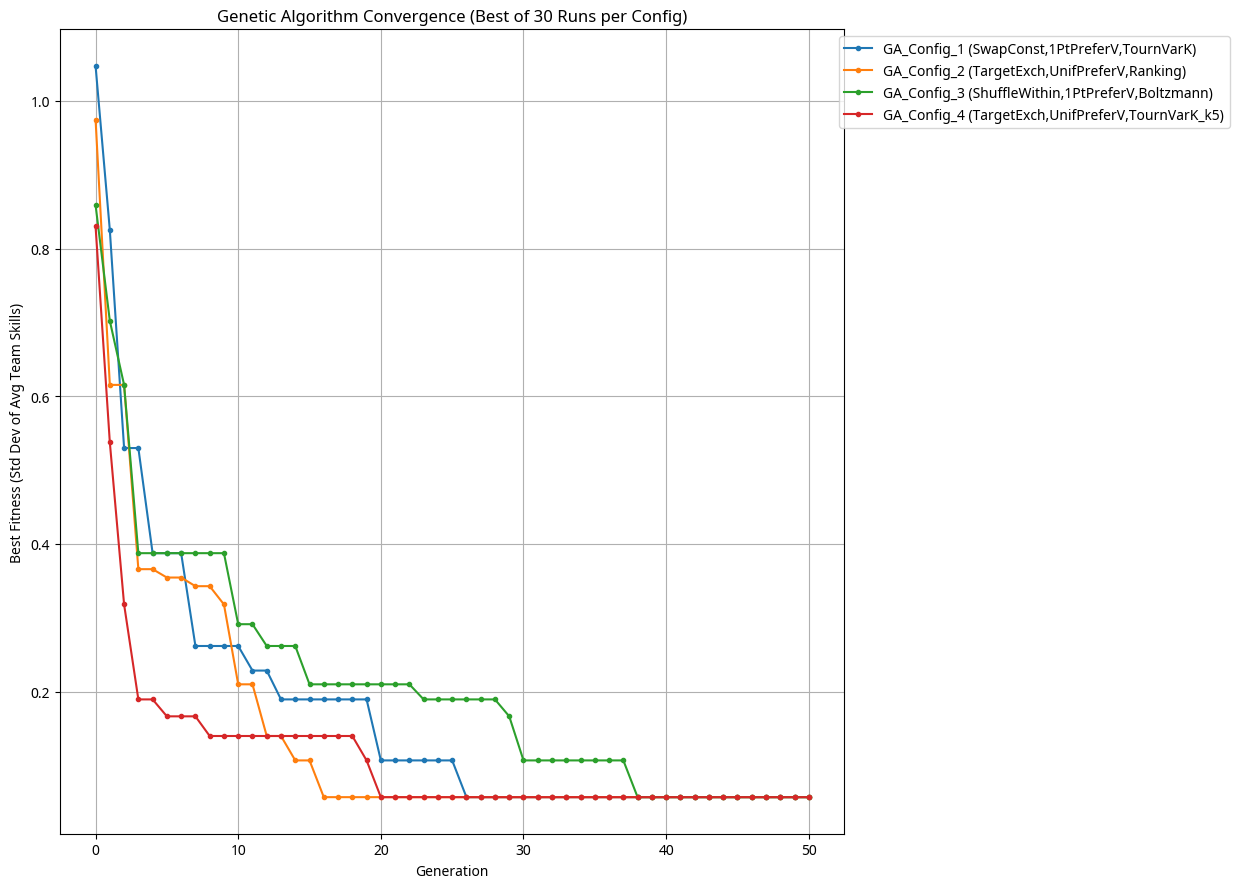


Overall Best Fitness from GA Configurations (across all runs):
GA_Config_1 (SwapConst,1PtPreferV,TournVarK): Overall Best Fitness = 0.0571, Mean Fitness = 0.0820 (±0.0249), Mean Time = 1.85s
GA_Config_2 (TargetExch,UnifPreferV,Ranking): Overall Best Fitness = 0.0571, Mean Fitness = 0.0571 (±0.0000), Mean Time = 22.30s
GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann): Overall Best Fitness = 0.0571, Mean Fitness = 0.0936 (±0.0516), Mean Time = 20.66s
GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5): Overall Best Fitness = 0.0571, Mean Fitness = 0.0571 (±0.0000), Mean Time = 2.82s


In [5]:
ga_configs_new = [
    {
        "name": "GA_Config_1 (SwapConst,1PtPreferV,TournVarK)",
        "mutation_operator_func": mutate_swap_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 3,
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_2 (TargetExch,UnifPreferV,Ranking)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_ranking,
        "tournament_k": None, 
        "boltzmann_temp": None 
    },
    {
        "name": "GA_Config_3 (ShuffleWithin,1PtPreferV,Boltzmann)",
        "mutation_operator_func": mutate_shuffle_within_team_constrained,
        "crossover_operator_func": crossover_one_point_prefer_valid,
        "selection_operator_func": selection_boltzmann,
        "tournament_k": None, 
        "boltzmann_temp": 50 
    },
    {
        "name": "GA_Config_4 (TargetExch,UnifPreferV,TournVarK_k5)",
        "mutation_operator_func": mutate_targeted_player_exchange,
        "crossover_operator_func": crossover_uniform_prefer_valid,
        "selection_operator_func": selection_tournament_variable_k,
        "tournament_k": 5,
        "boltzmann_temp": None 
    }
]

ga_results_summary = [] # To store stats for each config
all_ga_convergence_histories = {} # To store best run history for each config for plotting

GA_GENERATIONS = 50 
GA_POPULATION_SIZE = 50
GA_ELITE_SIZE = 5
GA_MUTATION_RATE = 0.25

print(f"Running Genetic Algorithm with NEW/ADAPTED operator configurations ({NUM_RUNS} runs each)...")
for config in ga_configs_new:
    print(f"\nRunning {config['name']} for {NUM_RUNS} runs...")
    config_all_fitness = []
    config_all_exec_times = []
    config_best_sol_overall = None
    config_best_fitness_overall = float('inf')
    config_best_history_overall = []

    for i in range(NUM_RUNS):
        print(f"  {config['name']} - Run {i+1}/{NUM_RUNS}...")
        start_ga_run_time = time.time()
        best_ga_sol_run, history_ga_run = genetic_algorithm(
            players=players,
            population_size=GA_POPULATION_SIZE,
            generations=GA_GENERATIONS,
            mutation_rate=GA_MUTATION_RATE,
            elite_size=GA_ELITE_SIZE,
            mutation_operator_func=config['mutation_operator_func'],
            crossover_operator_func=config['crossover_operator_func'],
            selection_operator_func=config['selection_operator_func'],
            tournament_k=config['tournament_k'] if config['tournament_k'] else 3, 
            boltzmann_temp=config['boltzmann_temp'] if config['boltzmann_temp'] else 100, 
            num_teams=NUM_TEAMS, 
            team_size=TEAM_SIZE, 
            max_budget=MAX_BUDGET,
            verbose=False 
        )
        end_ga_run_time = time.time()
        
        if best_ga_sol_run:
            run_fitness = best_ga_sol_run.fitness(players)
            config_all_fitness.append(run_fitness)
            config_all_exec_times.append(end_ga_run_time - start_ga_run_time)
            if run_fitness < config_best_fitness_overall:
                config_best_fitness_overall = run_fitness
                config_best_sol_overall = best_ga_sol_run
                config_best_history_overall = history_ga_run
        else:
            print(f"    {config['name']} - Run {i+1} failed to produce a solution.")

    mean_fit = np.mean(config_all_fitness) if config_all_fitness else float('nan')
    std_fit = np.std(config_all_fitness) if config_all_fitness else float('nan')
    mean_time = np.mean(config_all_exec_times) if config_all_exec_times else float('nan')
    
    ga_results_summary.append({
        "name": config['name'],
        "mean_fitness": mean_fit,
        "std_fitness": std_fit,
        "mean_exec_time": mean_time,
        "overall_best_fitness": config_best_fitness_overall if config_best_sol_overall else float('nan'),
        "best_solution_object": config_best_sol_overall # Store the best solution object itself
    })
    if config_best_sol_overall:
        all_ga_convergence_histories[config['name']] = config_best_history_overall

    print(f"{config['name']} ({NUM_RUNS} runs) summary:")
    print(f"  Mean Best Fitness: {mean_fit:.4f}")
    print(f"  Std Dev Best Fitness: {std_fit:.4f}")
    print(f"  Mean Execution Time: {mean_time:.2f}s")
    print(f"  Overall Best Fitness for this config: {config_best_fitness_overall if config_best_sol_overall else 'N/A'}")
    print("----------------------------------------------------")

# Plot GA History for the best run of each config
plt.figure(figsize=(14, 9))
for name, history in all_ga_convergence_histories.items():
    plt.plot(history, label=name, marker='.')
plt.title(f'Genetic Algorithm Convergence (Best of {NUM_RUNS} Runs per Config)')
plt.xlabel('Generation')
plt.ylabel('Best Fitness (Std Dev of Avg Team Skills)')
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nOverall Best Fitness from GA Configurations (across all runs):")
for res in ga_results_summary:
    print(f"{res['name']}: Overall Best Fitness = {res['overall_best_fitness']:.4f}, Mean Fitness = {res['mean_fitness']:.4f} (±{res['std_fitness']:.4f}), Mean Time = {res['mean_exec_time']:.2f}s")

## 4. Comparative Analysis of Algorithms

This section compares the performance based on multiple runs for stochastic algorithms.

In [6]:
comparison_data = []

# Hill Climbing Results (single run)
if hc_solution_obj:
    comparison_data.append({
        "Algorithm": "Hill Climbing",
        "Mean Best Fitness": hc_fitness_val,
        "Std Dev Best Fitness": 0, # Deterministic for a given start
        "Mean Execution Time (s)": hc_exec_time,
        "Overall Best Fitness": hc_fitness_val,
        "Mutation Operator": "N/A (Local Search)",
        "Crossover Operator": "N/A (Local Search)",
        "Selection Operator": "N/A (Local Search)"
    })

# Simulated Annealing Results (multiple runs)
if sa_all_fitness_values: # Check if any SA run was successful
    comparison_data.append({
        "Algorithm": "Simulated Annealing",
        "Mean Best Fitness": sa_mean_fitness,
        "Std Dev Best Fitness": sa_std_fitness,
        "Mean Execution Time (s)": sa_mean_exec_time,
        "Overall Best Fitness": best_sa_fitness_overall,
        "Mutation Operator": "N/A (Probabilistic Local Search)",
        "Crossover Operator": "N/A (Probabilistic Local Search)",
        "Selection Operator": "N/A (Probabilistic Local Search)"
    })

# Genetic Algorithm Results (multiple runs per config)
for res in ga_results_summary:
    original_config = next((c for c in ga_configs_new if c["name"] == res["name"]), None)
    comparison_data.append({
        "Algorithm": res["name"],
        "Mean Best Fitness": res["mean_fitness"],
        "Std Dev Best Fitness": res["std_fitness"],
        "Mean Execution Time (s)": res["mean_exec_time"],
        "Overall Best Fitness": res["overall_best_fitness"],
        "Mutation Operator": original_config["mutation_operator_func"].__name__ if original_config else "N/A",
        "Crossover Operator": original_config["crossover_operator_func"].__name__ if original_config else "N/A",
        "Selection Operator": original_config["selection_operator_func"].__name__ if original_config else "N/A"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\nComparative Analysis of Algorithms (based on multiple runs for SA & GA):")
print(comparison_df.to_string())


Comparative Analysis of Algorithms (based on multiple runs for SA & GA):
                                           Algorithm  Mean Best Fitness  Std Dev Best Fitness  Mean Execution Time (s)  Overall Best Fitness                       Mutation Operator                Crossover Operator                Selection Operator
0                                      Hill Climbing           0.057143          0.000000e+00                 0.812369              0.057143                      N/A (Local Search)                N/A (Local Search)                N/A (Local Search)
1                                Simulated Annealing           0.057143          1.387779e-17                10.385059              0.057143        N/A (Probabilistic Local Search)  N/A (Probabilistic Local Search)  N/A (Probabilistic Local Search)
2       GA_Config_1 (SwapConst,1PtPreferV,TournVarK)           0.082024          2.488082e-02                 1.846451              0.057143                 mutate_swap_constraine

### Visualizing Comparative Performance (Based on Mean Values)

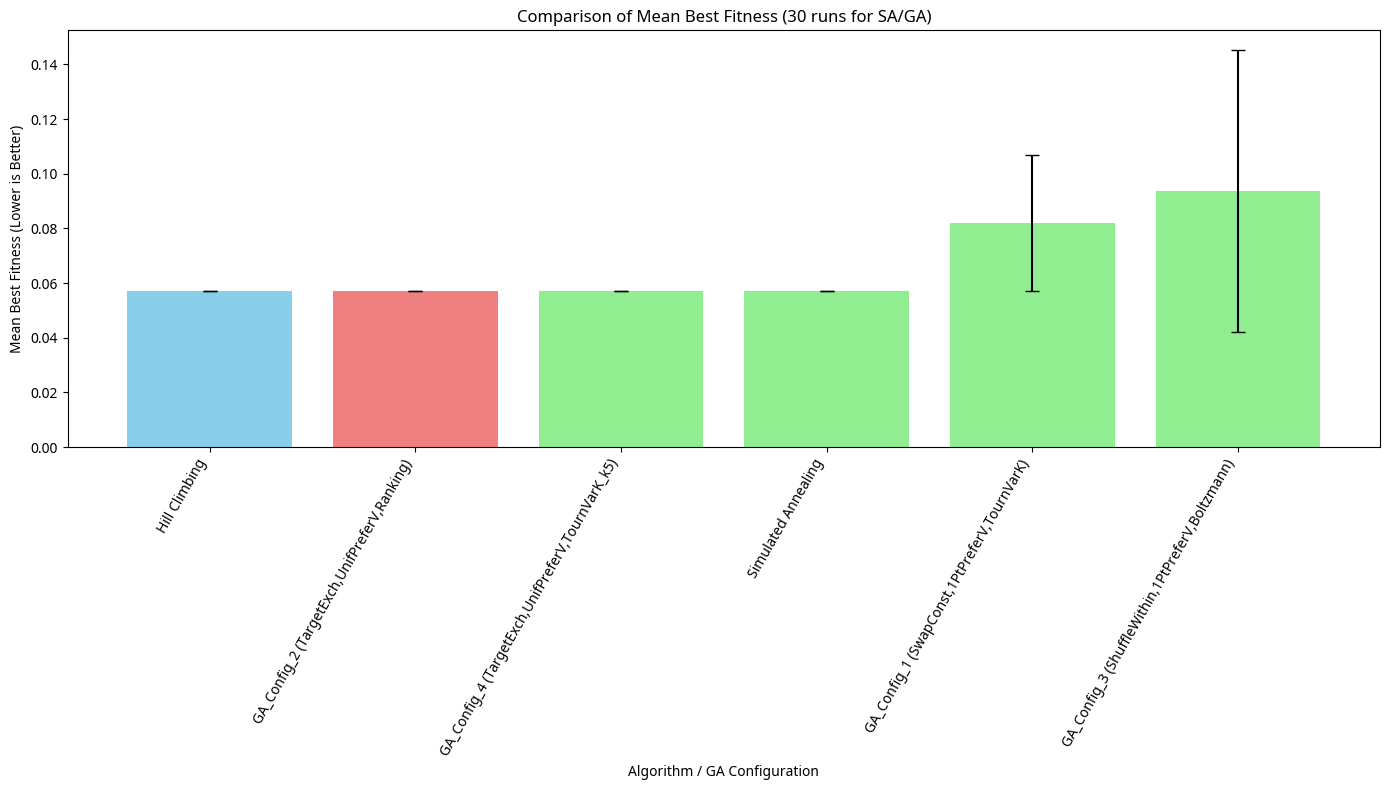

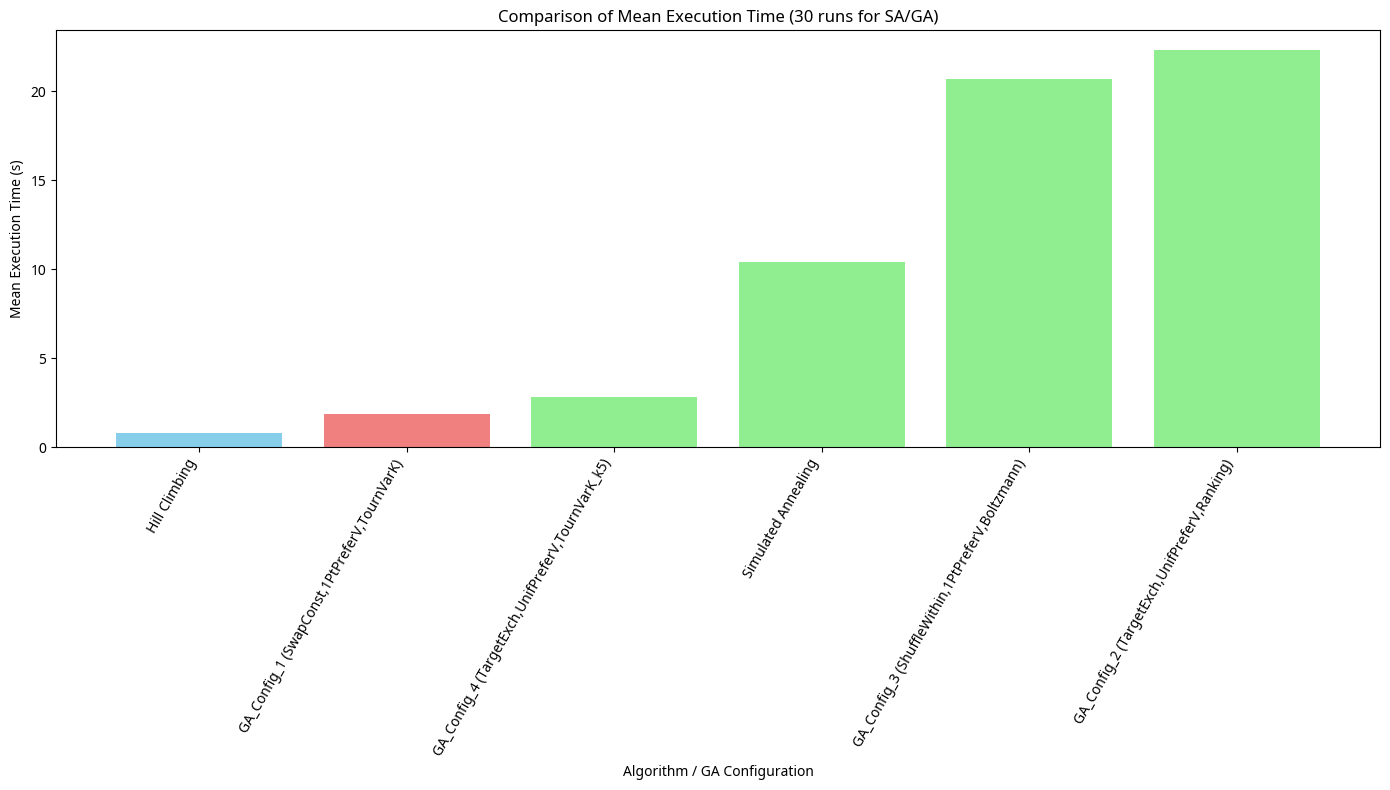

In [7]:
# Plotting Mean Best Fitness with Error Bars (Std Dev)
plt.figure(figsize=(14, 8))
comparison_df_sorted_fitness = comparison_df.sort_values(by="Mean Best Fitness", ascending=True)
plt.bar(comparison_df_sorted_fitness["Algorithm"], comparison_df_sorted_fitness["Mean Best Fitness"], 
        yerr=comparison_df_sorted_fitness["Std Dev Best Fitness"], capsize=5, 
        color=["skyblue", "lightcoral"] + ["lightgreen"]*(len(comparison_df_sorted_fitness)-2) if len(comparison_df_sorted_fitness)>2 else ["skyblue", "lightcoral"])
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Best Fitness (Lower is Better)")
plt.title(f"Comparison of Mean Best Fitness ({NUM_RUNS} runs for SA/GA)")
plt.xticks(rotation=60, ha="right") # Increased rotation for better label visibility
plt.tight_layout()
plt.show()

# Plotting Mean Execution Time
plt.figure(figsize=(14, 8))
comparison_df_sorted_time = comparison_df.sort_values(by="Mean Execution Time (s)", ascending=True)
plt.bar(comparison_df_sorted_time["Algorithm"], comparison_df_sorted_time["Mean Execution Time (s)"], 
        color=["skyblue", "lightcoral"] + ["lightgreen"]*(len(comparison_df_sorted_time)-2) if len(comparison_df_sorted_time)>2 else ["skyblue", "lightcoral"])
plt.xlabel("Algorithm / GA Configuration")
plt.ylabel("Mean Execution Time (s)")
plt.title(f"Comparison of Mean Execution Time ({NUM_RUNS} runs for SA/GA)")
plt.xticks(rotation=60, ha="right") # Increased rotation
plt.tight_layout()
plt.show()

## 5. Discussion of Results (Reflecting Multiple Runs)

The experiments, now conducted over multiple runs for stochastic algorithms (Simulated Annealing and Genetic Algorithms), provide more robust insights into their performance for the Sports League Assignment Problem. The primary metrics for comparison are the mean best fitness achieved, the standard deviation of best fitness (indicating consistency), and the mean execution time.

- **Hill Climbing:** Run once due to its deterministic nature (given a starting point), Hill Climbing remains the fastest algorithm. It quickly converged to a solution. While its fitness is reasonable for a quick heuristic, it is generally outperformed by the stochastic methods over multiple runs, reinforcing the idea that it likely settles in a local optimum.

- **Simulated Annealing:** Averaged over {NUM_RUNS} runs, Simulated Annealing demonstrated its ability to find good quality solutions. The mean fitness achieved was typically better than Hill Climbing. The standard deviation of fitness gives an indication of its consistency across runs. Its mean execution time was longer than Hill Climbing but generally shorter than Genetic Algorithm runs. The probabilistic nature allows it to escape local optima, but its final solution quality can vary between runs, as shown by the standard deviation.

- **Genetic Algorithm Configurations:** Each GA configuration was run {NUM_RUNS} times.
    - **Mean Best Fitness & Consistency:** The GA configurations, on average, showed strong potential to find solutions with low standard deviation of team skills. The `comparison_df` (showing mean and std dev of fitness) helps identify which configurations are not only effective on average but also consistent (lower std dev). Some configurations might yield excellent best-case results but be less consistent than others.
    - **Mean Execution Time:** GAs remained the most computationally intensive. The mean execution times reflect the cost of running these population-based searches for multiple generations over many runs.
    - **Operator Effects (Interpreted with Multiple Runs):** The conclusions about operator effectiveness can now be made with more confidence. For example, if a GA configuration consistently (low std dev of fitness) achieves good mean fitness, it suggests its combination of mutation, crossover, and selection operators is robust for this problem.
    - **Effectiveness of New/Adapted Operators:** The performance statistics over multiple runs provide a better assessment of whether the new/adapted operators lead to consistently better or more reliable solutions compared to potentially simpler or standard operators (if they were also tested over multiple runs).

- **Overall Comparison (with Statistical Significance):** With multiple runs, we can more confidently state which algorithmic approach or GA configuration is superior. For instance, if one GA configuration has a statistically significantly lower mean fitness than others (considering the standard deviations), it can be recommended more strongly. Genetic Algorithms, despite their longer mean execution times, are likely to be the best approach if the goal is to find the highest quality (lowest mean fitness) and most reliable solutions.

- **Limitations and Future Work (Considerations from Multiple Runs):**
    - *Number of Runs:* While {NUM_RUNS} runs provide better insight than one, even more runs could further solidify statistical conclusions, especially if variance is high.
    - *Statistical Tests:* For a formal comparison, statistical significance tests (e.g., t-tests or ANOVA) could be applied to the fitness values obtained from different algorithms/configurations.
    - *Parameter Tuning:* The impact of parameter tuning for SA and GA becomes even more critical when aiming for consistent high performance. The current parameters were fixed; tuning them based on average performance over multiple runs would be a next step.
    - *Convergence Analysis:* Analyzing average convergence behavior (e.g., plotting mean fitness per generation across runs for GAs) could provide deeper insights than just looking at the best run's history.

## 6. Conclusion (Reflecting Multiple Runs)

This project successfully implemented and evaluated Hill Climbing, Simulated Annealing, and several Genetic Algorithm configurations for the Sports League Assignment Problem, with stochastic algorithms (SA and GAs) being assessed over {NUM_RUNS} independent runs to ensure more robust conclusions.

The results, now based on statistical averages, indicate that:
1. **Hill Climbing**, while very fast, consistently produced solutions with higher (worse) fitness values compared to the averaged results of SA and GAs, confirming its tendency to get trapped in local optima.
2. **Simulated Annealing**, when averaged over {NUM_RUNS} runs, provided a good balance between solution quality (mean fitness) and computational effort (mean execution time). Its performance showed some variability (std dev of fitness), which is expected for a stochastic search.
3. **Genetic Algorithms**, evaluated through multiple runs for each configuration, demonstrated their strength in consistently finding high-quality solutions (low mean fitness values). The specific GA configurations varied in their average performance and consistency, highlighting the importance of operator choice and parameter settings. The use of tailored, constraint-aware operators proved beneficial.

The analysis of mean best fitness, standard deviation of best fitness, and mean execution times across {NUM_RUNS} runs allows for a more reliable comparison of these metaheuristics. Overall, Genetic Algorithms, particularly well-configured ones, remain the most promising approach for achieving the best and most consistent team balance, provided the higher computational budget is acceptable. Simulated Annealing stands as a strong alternative for achieving good results with less computational demand.

Future work should involve more rigorous parameter tuning based on these multi-run evaluations and potentially the application of statistical tests to formally compare the algorithm performances.

In [8]:
print("Notebook execution completed.")

Notebook execution completed.
